### Loading in files & libraries.

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string

from collections import defaultdict, Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
water_df = pd.read_csv('water.csv', parse_dates= ['SAMPLE_DATE'])

In [3]:
complaint_df = pd.read_csv('complaints.csv')

## Water Dataframe Exploration

### Initial Exploration

These first lines just let me see and understand the dataset.

In [4]:
water_df.head()

,DATA_REF_NO,DEPTH_IN_METERS,FILTER,LAT_DD_WGS84,LON_DD_WGS84,MEDIUM,METHOD,PARAM_TYPE,PARAMETER,PROJECT,...,RESULT,SAMPLE_DATE,SAMPLE_ID,SAMPLE_REF_NO,SAMPLE_SITE_NO,SITE_NAME,SITE_TYPE,TIME_NULL,UNIT,WATERSHED
0,2308323,NaN,Total,30.251205,-97.780891,Ground Water,UNKNOWN,Nutrients,NITRATE AS N,Groundwater,...,1.5,1947-12-07,NaN,448739,735,USGS Well 301526097463201 (Rabb Well),Well,Y,MG/L,Barton Creek
1,2308163,NaN,Total,30.251205,-97.780891,Ground Water,UNKNOWN,Major Ions,CHLORIDE,Groundwater,...,14.0,1947-12-07,NaN,448739,735,USGS Well 301526097463201 (Rabb Well),Well,Y,MG/L,Barton Creek
2,2308160,NaN,Total,30.251205,-97.780891,Ground Water,UNKNOWN,Major Ions,SODIUM,Groundwater,...,10.0,1947-12-07,NaN,448739,735,USGS Well 301526097463201 (Rabb Well),Well,Y,MG/L,Barton Creek
3,2308159,NaN,Total,30.251205,-97.780891,Ground Water,UNKNOWN,Major Ions,MAGNESIUM,Groundwater,...,20.0,1947-12-07,NaN,448739,735,USGS Well 301526097463201 (Rabb Well),Well,Y,MG/L,Barton Creek
4,2308158,NaN,Total,30.251205,-97.780891,Ground Water,UNKNOWN,Major Ions,CALCIUM,Groundwater,...,55.0,1947-12-07,NaN,448739,735,USGS Well 301526097463201 (Rabb Well),Well,Y,MG/L,Barton Creek


In [5]:
water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448827 entries, 0 to 1448826
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   DATA_REF_NO      1448827 non-null  int64         
 1   DEPTH_IN_METERS  159152 non-null   float64       
 2   FILTER           1422585 non-null  object        
 3   LAT_DD_WGS84     1416068 non-null  float64       
 4   LON_DD_WGS84     1416068 non-null  float64       
 5   MEDIUM           1448827 non-null  object        
 6   METHOD           1448827 non-null  object        
 7   PARAM_TYPE       1448827 non-null  object        
 8   PARAMETER        1448827 non-null  object        
 9   PROJECT          1448827 non-null  object        
 10  QC_FLAG          1361838 non-null  object        
 11  QC_TYPE          46966 non-null    object        
 12  QUALIFIER        233299 non-null   object        
 13  RESULT           1448210 non-null  float64       
 14  SA

In [6]:
water_df.describe(include=object).T

,count,unique,top,freq
FILTER,1422585,26,Total,1316830
MEDIUM,1448827,37,Surface Water,294723
METHOD,1448827,432,VISUAL ASSESSMENT,260387
PARAM_TYPE,1448827,101,Habitat Evaluation,162357
PARAMETER,1448827,3394,WATER TEMPERATURE,32418
PROJECT,1448827,183,Environmental Integrity Index (EII),132836
QC_FLAG,1361838,8,U,1247901
QC_TYPE,46966,11,Field Replica,33848
QUALIFIER,233299,48,<,129596
SAMPLE_ID,1064775,45758,NC,4855


In [7]:
water_df.PARAM_TYPE.value_counts()

PARAM_TYPE
Habitat Evaluation            162357
Nutrients                     120867
Benthic Macroinvertebrates     91888
Calculated Metrics             83127
Riparian Vegetation            77108
                               ...  
Phaeophyte                         2
Riparian Graminoids                2
Phthalates                         1
Diphenolics                        1
Benzothiadiazoles                  1
Name: count, Length: 101, dtype: int64

In [8]:
water_df.describe().T

,count,mean,min,25%,50%,75%,max,std
DATA_REF_NO,1448827.0,1777679.423829,1.0,1151170.5,1877713.0,2532474.5,3000655.0,848449.014654
DEPTH_IN_METERS,159152.0,2.700056,0.0,0.2,0.4816,3.0,2124.0,31.105359
LAT_DD_WGS84,1416068.0,30.28411,0.0,30.251205,30.267717,30.332573,30.703279,0.277223
LON_DD_WGS84,1416068.0,-97.762964,-98.402136,-97.812697,-97.770061,-97.725116,0.0,0.858709
RESULT,1448210.0,-131068722077589632.0,-69854810000000003604480.0,0.108,3.0,19.0,2468674499999999983616.0,100707763663324971008.0
SAMPLE_DATE,1448827,2008-11-05 07:42:22.018239744,1947-12-07 00:00:00,2002-10-31 11:30:00,2009-10-09 12:59:00,2014-04-30 13:00:00,2023-12-22 12:00:00,NaN
SAMPLE_REF_NO,1448827.0,352425.497558,6.0,249153.0,363367.0,502557.5,594001.0,178793.616674
SAMPLE_SITE_NO,1448827.0,2525.660621,1.0,236.0,926.0,3977.0,13680.0,3366.617133


In [9]:
water_df.isna().sum()

DATA_REF_NO              0
DEPTH_IN_METERS    1289675
FILTER               26242
LAT_DD_WGS84         32759
LON_DD_WGS84         32759
MEDIUM                   0
METHOD                   0
PARAM_TYPE               0
PARAMETER                0
PROJECT                  0
QC_FLAG              86989
QC_TYPE            1401861
QUALIFIER          1215528
RESULT                 617
SAMPLE_DATE              0
SAMPLE_ID           384052
SAMPLE_REF_NO            0
SAMPLE_SITE_NO           0
SITE_NAME                0
SITE_TYPE                0
TIME_NULL                0
UNIT                 65148
WATERSHED                0
dtype: int64

### Trimming to relevant columns

In [10]:
# Dropped columns where the data was irrelevant to business problem, redundant to other columns, or had too little data to model effectively.

water_df = water_df.drop(columns= ['SITE_NAME', 'SAMPLE_ID', 'TIME_NULL', 'DATA_REF_NO', 'METHOD', 'FILTER', 'DEPTH_IN_METERS', 'QUALIFIER', 'QC_TYPE'])

In [11]:
# Decided I might want to trim to just one parameter type to manage types of sampling.

water_df.PARAM_TYPE.value_counts()

PARAM_TYPE
Habitat Evaluation            162357
Nutrients                     120867
Benthic Macroinvertebrates     91888
Calculated Metrics             83127
Riparian Vegetation            77108
                               ...  
Phaeophyte                         2
Riparian Graminoids                2
Phthalates                         1
Diphenolics                        1
Benzothiadiazoles                  1
Name: count, Length: 101, dtype: int64

In [12]:
## Decided I wanted to review only relevant samples from the past 13 years, to match complaints dataframe.

water_df.SAMPLE_DATE.min()

Timestamp('1947-12-07 00:00:00')

In [13]:
calc_h2o = (water_df[water_df['PARAM_TYPE'] == 'Calculated Metrics'])
calc_h2o= (calc_h2o[calc_h2o['SAMPLE_DATE'] >= '2005'])

### Exploring Water Dataset trimmed to 'Calculated Metrics' project, after 2010.

In [14]:
calc_h2o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46488 entries, 131341 to 1447289
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   LAT_DD_WGS84    46488 non-null  float64       
 1   LON_DD_WGS84    46488 non-null  float64       
 2   MEDIUM          46488 non-null  object        
 3   PARAM_TYPE      46488 non-null  object        
 4   PARAMETER       46488 non-null  object        
 5   PROJECT         46488 non-null  object        
 6   QC_FLAG         41626 non-null  object        
 7   RESULT          46488 non-null  float64       
 8   SAMPLE_DATE     46488 non-null  datetime64[ns]
 9   SAMPLE_REF_NO   46488 non-null  int64         
 10  SAMPLE_SITE_NO  46488 non-null  int64         
 11  SITE_TYPE       46488 non-null  object        
 12  UNIT            25981 non-null  object        
 13  WATERSHED       46488 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(8

In [15]:
calc_h2o.head()

,LAT_DD_WGS84,LON_DD_WGS84,MEDIUM,PARAM_TYPE,PARAMETER,PROJECT,QC_FLAG,RESULT,SAMPLE_DATE,SAMPLE_REF_NO,SAMPLE_SITE_NO,SITE_TYPE,UNIT,WATERSHED
131341,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,NUMBER OF ORGANISMS,Barton Creek Pool Study,S,1166.00,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek
131342,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,NUMBER OF TAXA,Barton Creek Pool Study,U,18.00,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek
131343,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,PERCENT DOMINANCE (TOP 1 TAXA),Barton Creek Pool Study,S,60.89,2005-01-25 10:00:00,290570,48,Stream,(%) Percent,Barton Creek
131344,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,HILSENHOFF BIOTIC INDEX,Barton Creek Pool Study,S,3.97,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek
131345,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,NUMBER OF DIPTERA TAXA,Barton Creek Pool Study,U,4.00,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek


In [16]:
calc_h2o.describe().T

,count,mean,min,25%,50%,75%,max,std
LAT_DD_WGS84,46488.0,30.287193,30.07402,30.239374,30.290256,30.34291,30.523889,0.087564
LON_DD_WGS84,46488.0,-97.755785,-98.221703,-97.814645,-97.75048,-97.680146,-97.394752,0.11989
RESULT,46488.0,44.177369,0.0,2.56,10.0,36.78,7378.0,142.432987
SAMPLE_DATE,46488,2013-04-27 07:36:26.450696960,2005-01-19 10:00:00,2008-02-06 16:00:00,2013-05-06 15:00:00,2018-05-02 12:00:00,2023-07-17 13:45:00,NaN
SAMPLE_REF_NO,46488.0,441165.260196,273469.0,323007.0,445490.0,558079.0,593913.0,109944.707413
SAMPLE_SITE_NO,46488.0,1944.878678,1.0,349.0,1100.0,3861.0,13562.0,2312.564533


In [17]:
calc_h2o.describe(include=object).T

,count,unique,top,freq
MEDIUM,46488,6,Benthic Macroinvertebrate,38738
PARAM_TYPE,46488,1,Calculated Metrics,46488
PARAMETER,46488,47,NUMBER OF ORGANISMS,2727
PROJECT,46488,30,Environmental Integrity Index (EII),16929
QC_FLAG,41626,3,U,39843
SITE_TYPE,46488,7,Stream,39426
UNIT,25981,6,(%) Percent,21422
WATERSHED,46488,69,Barton Creek,3649


In [18]:
calc_h2o['SITE_TYPE'].value_counts()

SITE_TYPE
Stream                       39426
Lake                          5984
Spring                         621
Sediment                       229
VIP Site                       180
Wastewater Plant Effluent       25
Vegetation Patch                23
Name: count, dtype: int64

### Feature Engineering: Sample Medium

In [19]:
Larvae = ['Benthic Macroinvertebrate']
Algae = ['Diatom', 'Surface Water']
Vegetation = ['Habitat Belt Transect', 'Vegetation', 'Leaf Pack']

In [20]:
def sample(MEDIUM):
    if MEDIUM in Larvae:
        return 1
    if MEDIUM in Algae:
        return 2
    if MEDIUM in Vegetation:
        return 3
    else:
        return 6

In [21]:
calc_h2o['Sample'] = calc_h2o['MEDIUM'].apply(sample)

In [22]:
calc_h2o.head()

,LAT_DD_WGS84,LON_DD_WGS84,MEDIUM,PARAM_TYPE,PARAMETER,PROJECT,QC_FLAG,RESULT,SAMPLE_DATE,SAMPLE_REF_NO,SAMPLE_SITE_NO,SITE_TYPE,UNIT,WATERSHED,Sample
131341,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,NUMBER OF ORGANISMS,Barton Creek Pool Study,S,1166.00,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek,1
131342,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,NUMBER OF TAXA,Barton Creek Pool Study,U,18.00,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek,1
131343,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,PERCENT DOMINANCE (TOP 1 TAXA),Barton Creek Pool Study,S,60.89,2005-01-25 10:00:00,290570,48,Stream,(%) Percent,Barton Creek,1
131344,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,HILSENHOFF BIOTIC INDEX,Barton Creek Pool Study,S,3.97,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek,1
131345,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,NUMBER OF DIPTERA TAXA,Barton Creek Pool Study,U,4.00,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek,1


### Feature Engineering: QC Flag & Trimming Redundancies

In [23]:
calc_h2o.QC_FLAG.value_counts()

QC_FLAG
U    39843
S     1283
J      500
Name: count, dtype: int64

In [24]:
U = ['U']
J = ['J']
S = ['S']

In [25]:
def flag(QC_FLAG):
    if QC_FLAG in U:
        return 1
    if QC_FLAG in J:
        return 2
    if QC_FLAG in S:
        return 3
    else:
        return 0

In [26]:
calc_h2o['QC_Flag'] = calc_h2o['QC_FLAG'].apply(flag)

In [27]:
# Why are they coming out as 6!? Can I join my datasets on Long/Latitude? Otherwise Sample ref number?
calc_h2o.head()

,LAT_DD_WGS84,LON_DD_WGS84,MEDIUM,PARAM_TYPE,PARAMETER,PROJECT,QC_FLAG,RESULT,SAMPLE_DATE,SAMPLE_REF_NO,SAMPLE_SITE_NO,SITE_TYPE,UNIT,WATERSHED,Sample,QC_Flag
131341,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,NUMBER OF ORGANISMS,Barton Creek Pool Study,S,1166.00,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek,1,3
131342,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,NUMBER OF TAXA,Barton Creek Pool Study,U,18.00,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek,1,1
131343,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,PERCENT DOMINANCE (TOP 1 TAXA),Barton Creek Pool Study,S,60.89,2005-01-25 10:00:00,290570,48,Stream,(%) Percent,Barton Creek,1,3
131344,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,HILSENHOFF BIOTIC INDEX,Barton Creek Pool Study,S,3.97,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek,1,3
131345,30.296248,-97.92613,Benthic Macroinvertebrate,Calculated Metrics,NUMBER OF DIPTERA TAXA,Barton Creek Pool Study,U,4.00,2005-01-25 10:00:00,290570,48,Stream,NaN,Barton Creek,1,1


In [28]:
calc_h2o = calc_h2o.drop(columns=['QC_FLAG', 'MEDIUM', 'PARAM_TYPE', 'UNIT'])

## Complaint Dataframe Exploration

### Initial Introductory Exploration

In [29]:
complaint_df.head()

,Customer Number,Customer Name,Regulated Entity Number,Regulated Entity Name,Mailing Address,Mailing State,Mailing Zip Code,County,Physical Location,Physical City,...,Incident Source,Incident Status,Incident Description,Incident Action Taken,Incident Comment,Material Released,Material Released Amount,Spill Classification,TCEQ Region,Coordinates (Decimal Degrees)
0,NaN,NaN,RN103341053,"RODRIGUEZ, OMAR",NaN,NaN,NaN,CAMERON,NaN,NaN,...,NaN,CLOSED,NaN,NaN,NaN,NaN,NaN,NaN,REGION 15 - HARLINGEN,NaN
1,NaN,NaN,RN103154688,I-10 EAST PLANT,NaN,NaN,NaN,HARRIS,UNSPECIFIED LOCATION,NaN,...,NaN,CLOSED,NaN,NaN,NaN,NaN,NaN,NaN,REGION 12 - HOUSTON,NaN
2,NaN,NaN,RN104032552,GENERIC INCIDENT ZIP CODE 75050,NaN,NaN,NaN,DALLAS,NaN,GRAND PRARIE,...,NaN,CLOSED,NaN,NaN,NaN,NaN,NaN,NaN,REGION 04 - DFW METROPLEX,NaN
3,NaN,NaN,RN101280493,COTTON VALLEY RV PARK,NaN,NaN,NaN,NO COUNTY NAME,NaN,NaN,...,NaN,CLOSED,FUEL LEAKING FROM DISPENSER #2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,RN104046297,GENERIC INCIDENT ZIP CODE 77550,NaN,NaN,NaN,GALVESTON,NaN,GALVESTON,...,NaN,CLOSED,Smells like sulfur.,Assigned to investigator.,NaN,NaN,NaN,NaN,REGION 12 - HOUSTON,NaN


In [30]:
complaint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215548 entries, 0 to 215547
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Customer Number                192445 non-null  object 
 1   Customer Name                  192445 non-null  object 
 2   Regulated Entity Number        215546 non-null  object 
 3   Regulated Entity Name          215546 non-null  object 
 4   Mailing Address                94682 non-null   object 
 5   Mailing State                  94682 non-null   object 
 6   Mailing Zip Code               94353 non-null   float64
 7   County                         215489 non-null  object 
 8   Physical Location              96982 non-null   object 
 9   Physical City                  178223 non-null  object 
 10  Latitude                       60650 non-null   float64
 11  Longitude                      60650 non-null   float64
 12  Incident Number               

In [31]:
complaint_df.describe(include=object).T

,count,unique,top,freq
Customer Number,192445,33571,CN602295370,41316
Customer Name,192445,33367,GENERIC INCIDENT PRINCIPAL,41316
Regulated Entity Number,215546,47975,RN102610102,5642
Regulated Entity Name,215546,46417,BLUE RIDGE LANDFILL,5642
Mailing Address,94682,29017,2200 FM 521 RD,5642
Mailing State,94682,12,TX,94649
County,215489,255,HARRIS,15205
Physical Location,96982,26356,LOCATED ON 2200 FM 521,5642
Physical City,178223,2098,HOUSTON,7726
Incident Received Date,215548,7275,"Oct 29, 2018",292


In [32]:
complaint_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Mailing Zip Code,94353.0,77264.966233,1341.570210,30097.0000,76106.0000,77494.0000,78264.0000,92154.0
Latitude,60650.0,30.659115,1.873095,4.7330,29.5806,30.2181,32.3972,82.8
Longitude,60650.0,97.230869,2.304337,9.8333,95.4319,97.1659,97.9089,107.0
Incident Number,215548.0,211925.007158,114695.755990,2237.0000,116793.7500,203734.5000,312490.0000,413877.0
Incident Priority,211353.0,5.252213,1.813253,1.0000,4.0000,5.0000,6.0000,8.0
Number Complaining,215548.0,1.098122,3.705954,0.0000,1.0000,1.0000,1.0000,1600.0


In [33]:
complaint_df['Media'].value_counts(normalize=True)

Media
WATER    0.405954
AIR      0.355561
WASTE    0.238484
Name: proportion, dtype: float64

In [34]:
wtf_df = (complaint_df[complaint_df['Material Released Amount'] == '16500 GALLONS'])
wtf_df.head()

,Customer Number,Customer Name,Regulated Entity Number,Regulated Entity Name,Mailing Address,Mailing State,Mailing Zip Code,County,Physical Location,Physical City,...,Incident Source,Incident Status,Incident Description,Incident Action Taken,Incident Comment,Material Released,Material Released Amount,Spill Classification,TCEQ Region,Coordinates (Decimal Degrees)
76157,CN600676522,CITY OF KILGORE,RN102079985,CITY OF KILGORE WWTP,2701 ANGELINE ST,TX,75662.0,GREGG,NaN,KILGORE,...,City of Kilgore WWTP Collection System,CLOSED,The Noncompliance Notification was received by...,The noncompliance has been assigned and will b...,More information will be available upon approv...,Sewage,16500 GALLONS,006 - OTHER SUBSTANCE,REGION 05 - TYLER,NaN


### Water-related Complaints Dataframe

In [35]:
complaint_h2o = (complaint_df[complaint_df['Media'] == 'WATER'])

In [36]:
complaint_h2o = complaint_h2o.drop(columns= ['Incident Number', 'Regulated Entity Number', 'Incident Comment', 'Mailing Address', 'Incident Start Date', 'Latitude', 'Longitude', 'Regulated Entity Name', 'Mailing Zip Code', 'Mailing State', 'Physical City', 'Number Complaining', 'Customer Name', 'Customer Number', 'Incident Source', 'Receiving Water Body', 'Spill Classification', 'Media', 'Nature', 'Material Released', 'Material Released Amount', 'Physical Location', 'Coordinates (Decimal Degrees)', 'Incident Action Taken'])

In [37]:
complaint_h2o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85867 entries, 5 to 215547
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   County                  85829 non-null  object 
 1   Incident Priority       84322 non-null  float64
 2   Incident Received Date  85867 non-null  object 
 3   Incident Status Date    85867 non-null  object 
 4   Effect                  85859 non-null  object 
 5   Frequency               85866 non-null  object 
 6   Incident Status         85867 non-null  object 
 7   Incident Description    85669 non-null  object 
 8   TCEQ Region             85759 non-null  object 
dtypes: float64(1), object(8)
memory usage: 6.6+ MB


In [38]:
# complaint_h2o['Regulated Entity Number'].duplicated().value_counts()

In [39]:
# complaint_h2o['Incident Number'].duplicated().value_counts()

In [40]:
complaint_h2o.head()

,County,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,1.0,"Jan 10, 2003","Jan 10, 2003",ENVIRONMEN,PAST,CLOSED,NaN,REGION 09 - WACO
8,ERATH,8.0,"Mar 20, 2009","Apr 28, 2016",ENVIRONMEN,CURRENT,CLOSED,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,5.0,"Aug 09, 2006","Aug 10, 2006",ENVIRONMEN,CURRENT,CLOSED,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,5.0,"Aug 18, 2014","Sep 02, 2014",HEALTH,CURRENT,REFERRED,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,8.0,"Aug 26, 2019","Sep 23, 2019",HEALTH,CURRENT,REFERRED,Alleged septic system installer operating with...,REGION 11 - AUSTIN


In [41]:
IRD_date = complaint_h2o["Incident Received Date"]
datetime_object = pd.to_datetime(IRD_date, format='%b %d, %Y')

complaint_h2o["Incident Received Date"] = datetime_object
print(datetime_object)

5        2003-01-10
8        2009-03-20
10       2006-08-09
21       2014-08-18
29       2019-08-26
            ...    
215525   2007-05-30
215532   2009-09-01
215537   2015-02-13
215545   2012-02-01
215547   2021-12-15
Name: Incident Received Date, Length: 85867, dtype: datetime64[ns]


In [42]:
stat_date = complaint_h2o["Incident Status Date"]
datetime_object = pd.to_datetime(stat_date, format='%b %d, %Y')

complaint_h2o["Incident Status Date"] = datetime_object
print(datetime_object)

5        2003-01-10
8        2016-04-28
10       2006-08-10
21       2014-09-02
29       2019-09-23
            ...    
215525   2007-09-11
215532   2009-10-19
215537   2015-02-24
215545   2012-02-06
215547   2022-02-02
Name: Incident Status Date, Length: 85867, dtype: datetime64[ns]


In [43]:
complaint_h2o.head()

,County,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,1.0,2003-01-10,2003-01-10,ENVIRONMEN,PAST,CLOSED,NaN,REGION 09 - WACO
8,ERATH,8.0,2009-03-20,2016-04-28,ENVIRONMEN,CURRENT,CLOSED,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,5.0,2006-08-09,2006-08-10,ENVIRONMEN,CURRENT,CLOSED,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,5.0,2014-08-18,2014-09-02,HEALTH,CURRENT,REFERRED,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,8.0,2019-08-26,2019-09-23,HEALTH,CURRENT,REFERRED,Alleged septic system installer operating with...,REGION 11 - AUSTIN


### Feature Engineering: Incident Status

In [44]:
complaint_h2o['Incident Status'].value_counts()

Incident Status
CLOSED      65846
REFERRED    20021
Name: count, dtype: int64

In [45]:
Closed = 'CLOSED'
Referred ='REFERRED'

In [46]:
def action(Incident):
    if Incident in Closed:
        return 1
    if Incident in Referred:
        return 2
    else:
        return 3

In [47]:
complaint_h2o['Incident Status'] = complaint_h2o['Incident Status'].apply(action)

In [48]:
complaint_h2o.loc[complaint_h2o['Incident Status'] == 3]

,County,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region


In [49]:
complaint_h2o.head()

,County,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,1.0,2003-01-10,2003-01-10,ENVIRONMEN,PAST,1,NaN,REGION 09 - WACO
8,ERATH,8.0,2009-03-20,2016-04-28,ENVIRONMEN,CURRENT,1,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,5.0,2006-08-09,2006-08-10,ENVIRONMEN,CURRENT,1,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,5.0,2014-08-18,2014-09-02,HEALTH,CURRENT,2,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,8.0,2019-08-26,2019-09-23,HEALTH,CURRENT,2,Alleged septic system installer operating with...,REGION 11 - AUSTIN


In [50]:
complaint_h2o = complaint_h2o.dropna(subset = ['Incident Priority'])

In [51]:
complaint_h2o['Incident Priority'] = complaint_h2o['Incident Priority'].astype(int)

### Feature Engineering: Incident Priority

In [52]:
complaint_h2o['Incident Priority'].value_counts()

Incident Priority
5    41732
8    21839
4    13510
3     2577
2     2300
1      935
6      863
7      566
Name: count, dtype: int64

In [53]:
High = [7, 8]
Mid = [4, 5, 6]
Low = [1, 2, 3]

In [54]:
def Rating(Priority):
    if Priority in High:
        return 3
    if Priority in Mid:
        return 2
    if Priority in Low:
        return 1
    else:
        return 4

In [55]:
complaint_h2o['Incident Priority'] = complaint_h2o['Incident Priority'].apply(Rating)

In [56]:
complaint_h2o.head()

,County,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,1,2003-01-10,2003-01-10,ENVIRONMEN,PAST,1,NaN,REGION 09 - WACO
8,ERATH,3,2009-03-20,2016-04-28,ENVIRONMEN,CURRENT,1,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,2,2006-08-09,2006-08-10,ENVIRONMEN,CURRENT,1,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,2,2014-08-18,2014-09-02,HEALTH,CURRENT,2,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,3,2019-08-26,2019-09-23,HEALTH,CURRENT,2,Alleged septic system installer operating with...,REGION 11 - AUSTIN


### Feature Engineering: Region 

In [57]:
complaint_h2o['TCEQ Region'] = complaint_h2o['TCEQ Region'].str.replace("REGION ",'')

In [58]:
complaint_h2o['Region'] = complaint_h2o['TCEQ Region'].str.split(" ").str[0]

In [59]:
complaint_h2o.dropna(subset='Region')
complaint_h2o = complaint_h2o.drop(columns=['TCEQ Region'])

In [60]:
complaint_h2o['Region'] = complaint_h2o['Region'].astype(float)

In [61]:
complaint_h2o = complaint_h2o.dropna(subset='Incident Description')

### Trimming Timeline & Exporting Clean Complaint CSV

In [62]:
complaint_clean = complaint_h2o[complaint_h2o['Incident Received Date'] >= '2005-01-01']

In [63]:
complaint_clean = complaint_clean.reset_index(drop=True)

In [64]:
df = complaint_clean[['County', 'Region', 'Incident Priority', 'Incident Status', 'Incident Received Date', 'Incident Status Date', 'Frequency', 'Effect', 'Incident Description']]
df.head()

,County,Region,Incident Priority,Incident Status,Incident Received Date,Incident Status Date,Frequency,Effect,Incident Description
0,ERATH,4.0,3,1,2009-03-20,2016-04-28,CURRENT,ENVIRONMEN,The Stephevnville office recieved a call about...
1,LEON,9.0,2,1,2006-08-09,2006-08-10,CURRENT,ENVIRONMEN,"Leon County: There is a water outage due to 8""..."
2,TARRANT,4.0,2,2,2014-08-18,2014-09-02,CURRENT,HEALTH,Complainant is concerned about the potential f...
3,LLANO,11.0,3,2,2019-08-26,2019-09-23,CURRENT,HEALTH,Alleged septic system installer operating with...
4,WILLIAMSON,11.0,3,2,2022-04-05,2022-04-18,INTERMITTENT,HEALTH,Complaint alleging wastewater was being discha...


In [65]:
df.to_csv('Data/clean_complaint.csv')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78193 entries, 0 to 78192
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   County                  78165 non-null  object        
 1   Region                  78133 non-null  float64       
 2   Incident Priority       78193 non-null  int64         
 3   Incident Status         78193 non-null  int64         
 4   Incident Received Date  78193 non-null  datetime64[ns]
 5   Incident Status Date    78193 non-null  datetime64[ns]
 6   Frequency               78192 non-null  object        
 7   Effect                  78186 non-null  object        
 8   Incident Description    78193 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 5.4+ MB


## Master Complaint Dataset EDA

In [67]:
df[['Incident Status Date', 'Incident Status','Region']].loc[df['Incident Priority'] == 3].corr() 


,Incident Status Date,Incident Status,Region
Incident Status Date,1.000000,0.142162,-0.072249
Incident Status,0.142162,1.000000,-0.060014
Region,-0.072249,-0.060014,1.000000


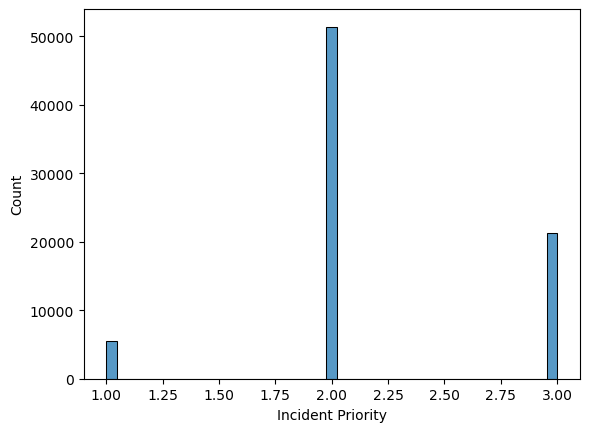

In [112]:
sns.histplot(df['Incident Priority']);

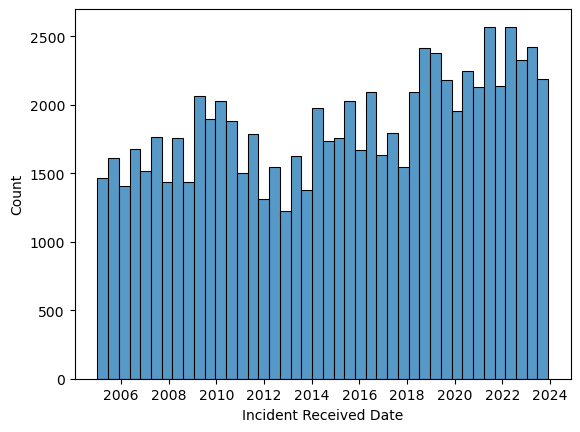

In [113]:
sns.histplot(df['Incident Received Date']);

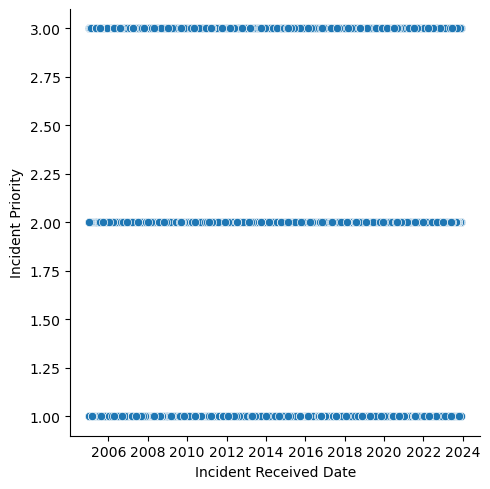

In [119]:
sns.relplot(
    x=df["Incident Received Date"], 
    y=df["Incident Priority"])

## NLP on Incident Description

### NLP Pre-processing on Top Incident Priority complaints

In [68]:
X = df['Incident Description']
y = df['Incident Priority']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)


In [73]:
sw = stopwords.words('english')

In [74]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [75]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [76]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [77]:
print(len(token_docs), len(X_train), len(y_train))

62554 62554 62554


In [78]:
# Check for missing values in X_train
missing_values_X_train = [idx for idx, doc in enumerate(X_train) if pd.isnull(doc)]
print(f"Number of missing values in X_train: {len(missing_values_X_train)}")

# Check for missing values in y_train
missing_values_y_train = [idx for idx, label in enumerate(y_train) if pd.isnull(label)]
print(f"Number of missing values in y_train: {len(missing_values_y_train)}")

Number of missing values in X_train: 0
Number of missing values in y_train: 0


In [79]:
pd.Series(token_docs).explode()

0        fall county complainant state pws leak front h...
1        complainant allege property obtained adequate ...
2        caller report track sediment william cannon st...
3        tceq tyler region office receive complaint was...
4        complainant allege someone run raw sewage onto...
                               ...                        
62549    complainant allege brown water local number co...
62550    complainant observe homeowner area faulty sept...
62551              complaint allege sewage plant smell bad
62552    complainant allege unauthorized discharge fail...
62553    july watermaster deputy john paul jones bander...
Length: 62554, dtype: object

### NLP Vectorizing & Top Priority Words dataframe

In [80]:
X_train_tuned, X_test_tuned, y_train_tuned, y_test_tuned = train_test_split(token_docs,
                                          y_train,
                                          test_size=0.2,
                                          random_state=42)

In [81]:
# Instantiate vectorizer and fit_transform it on the training set

cv = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words= sw, analyzer='word')

X_train_cv = cv.fit_transform(X_train_tuned)
X_train_cv = pd.DataFrame.sparse.from_spmatrix(X_train_cv)
X_train_cv.columns = sorted(cv.vocabulary_)
X_train_cv.set_index(y_train_tuned.index, inplace=True)

In [82]:
X_train_cv

,aa,aaa,aaffordablelandscape,aaig,aand,aaron,ab,abandon,abate,abatement,...,zoch,zoltek,zone,zoo,zoppes,zueger,zuehl,zulch,zumondo,zurita
23007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13720,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [83]:
# transform vectorizer on the validation set

X_test_tuned_cv = cv.transform(X_test_tuned)
X_test_tuned_cv = pd.DataFrame.sparse.from_spmatrix(X_test_tuned_cv)
X_test_tuned_cv.columns = sorted(cv.vocabulary_)
X_test_tuned_cv.set_index(y_test_tuned.index, inplace=True)

In [84]:
X_test_tuned_cv

,aa,aaa,aaffordablelandscape,aaig,aand,aaron,ab,abandon,abate,abatement,...,zoch,zoltek,zone,zoo,zoppes,zueger,zuehl,zulch,zumondo,zurita
76912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22931,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
top_priority_words = df[df['Incident Priority'] == 3]
top_priority_words = top_priority_words.reset_index(drop=True)
top_priority_words

,County,Region,Incident Priority,Incident Status,Incident Received Date,Incident Status Date,Frequency,Effect,Incident Description
0,ERATH,4.0,3,1,2009-03-20,2016-04-28,CURRENT,ENVIRONMEN,The Stephevnville office recieved a call about...
1,LLANO,11.0,3,2,2019-08-26,2019-09-23,CURRENT,HEALTH,Alleged septic system installer operating with...
2,WILLIAMSON,11.0,3,2,2022-04-05,2022-04-18,INTERMITTENT,HEALTH,Complaint alleging wastewater was being discha...
3,CORYELL,9.0,3,2,2021-05-27,2021-05-28,CURRENT,ENVIRONMEN,Concern of water billing issue.
4,HAYS,11.0,3,2,2020-05-27,2020-06-01,CURRENT,ENVIRONMEN,Alleged discharge of sewage from adjacent prop...
...,...,...,...,...,...,...,...,...,...
21251,HARRIS,12.0,3,2,2015-02-20,2015-02-24,CURRENT,ENVIRONMEN,Lots of dead bluegill and a few small bass in ...
21252,COMAL,13.0,3,1,2022-06-29,2022-07-15,CURRENT,GENERAL,The complaint alleges that the developer has n...
21253,NUECES,14.0,3,2,2021-07-09,2021-07-09,CURRENT,ENVIRONMEN,The complainant is concerned about erosion on ...
21254,MONTAGUE,3.0,3,1,2023-06-22,2023-06-23,CURRENT,ENVIRONMEN,A complainant alleges a facility in Montague C...


In [86]:
top_priority_token = [doc_preparer(doc, sw) for doc in top_priority_words['Incident Description']]

In [87]:
top_priority_cv = cv.fit_transform(top_priority_token)
top_priority_cv = pd.DataFrame.sparse.from_spmatrix(top_priority_cv)
top_priority_cv.columns = sorted(cv.vocabulary_)
#neg_token_cv.set_index(y_t.index, inplace=True)
top_priority_cv

,aa,aaron,ab,abandon,abate,abatement,abbey,abdominal,abel,abhorrently,...,zenith,zero,zerorez,zig,zinc,zip,zone,zoo,zuehl,zurita
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
top_priority_list = list(cv.get_feature_names_out())


top_priority_word_count = top_priority_cv.sum(axis=0)
top_priority_dict = dict(zip(top_priority_list, top_priority_word_count))

#neg_word_dict['app'] = neg_word_dict['apps']
#del neg_word_dict['apps']

sorted_top_priority_dict = dict(sorted(top_priority_dict.items(), key=lambda item: item[1], reverse=True)[:25])
sorted_top_priority_dict

{'complainant': 20492,
 'allege': 11218,
 'water': 9411,
 'sewage': 4866,
 'property': 4574,
 'system': 4146,
 'discharge': 3930,
 'state': 3829,
 'complaint': 3484,
 'septic': 3364,
 'county': 3162,
 'site': 2255,
 'tceq': 2250,
 'receive': 2235,
 'texas': 2156,
 'concern': 2098,
 'onto': 2079,
 'creek': 2026,
 'odor': 1919,
 'construction': 1882,
 'office': 1857,
 'city': 1799,
 'ground': 1776,
 'home': 1585,
 'cause': 1580}

In [89]:
top_priority_word_df = pd.DataFrame(sorted_top_priority_dict.items(), columns=['word', 'weight'])
cols = top_priority_word_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
top_priority_word_df = top_priority_word_df[cols]
top_priority_word_df

,weight,word
0,20492,complainant
1,11218,allege
2,9411,water
3,4866,sewage
4,4574,property
5,4146,system
6,3930,discharge
7,3829,state
8,3484,complaint
9,3364,septic


In [90]:
# frequency_distribution = Counter(sorted_top_priority_dict)
# print(frequency_distribution)

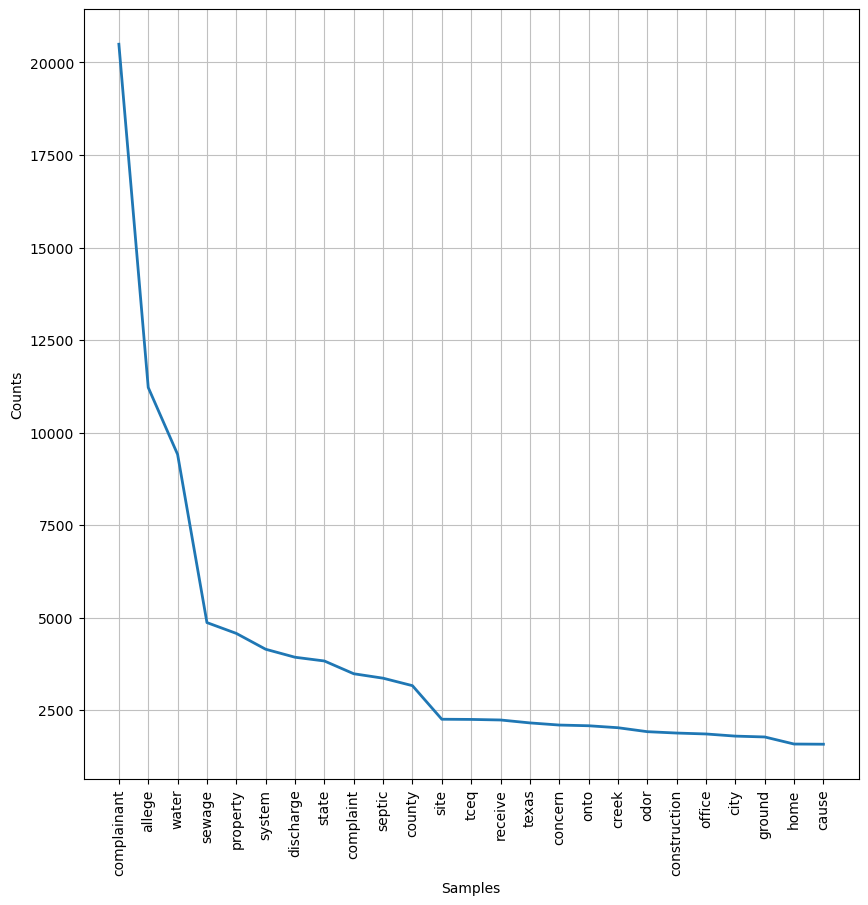

In [91]:
fdist = FreqDist(sorted_top_priority_dict)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [92]:
tf = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw, analyzer='word')
X_tf = tf.fit_transform(df['Incident Description'])

df_tf = pd.DataFrame(X_tf.toarray(), columns=tf.get_feature_names_out())
df_tf.head()

,a's,aa,aa's,aaa,aaffordablelandscape,aaig,aand,aaron,ab,abandon,...,zoning,zoo,zoological,zoppes,zueger,zuehl,zulch,zumondo,zurita,zwinggi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
tfidf_dict = tf.vocabulary_
#{k: v for k, v in sorted(tf_values.items(), key = lambda item: item[1], reverse=True)}
sorted_tfidf_dict = dict(sorted(tfidf_dict.items(), key=lambda item: item[1], reverse=True))

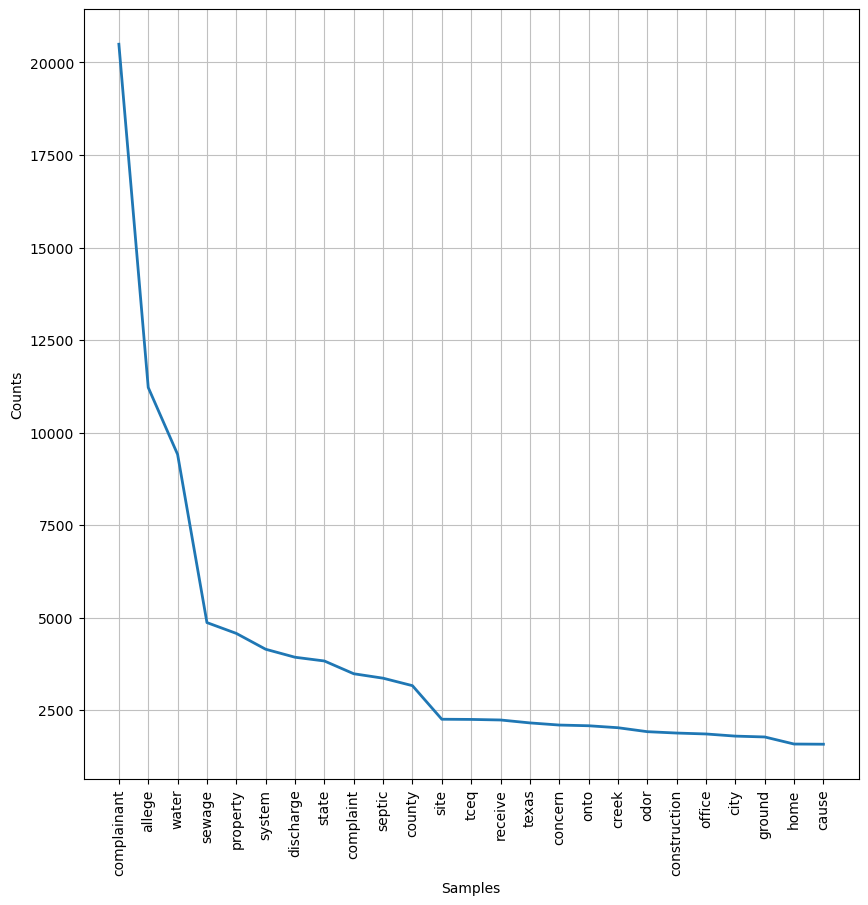

In [94]:
tfidf_dist = FreqDist(sorted_tfidf_dict)
plt.figure(figsize=(10, 10))
fdist.plot(30);

## Multinomial Bayes model

In [98]:
mnb_pipe = Pipeline([
    ('cv', cv), 
    ('mnb', MultinomialNB(alpha=0.05))])

In [101]:
mnb_pipe.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                ('mnb', MultinomialNB(alpha=0.05))])

In [102]:
cross_val_score(mnb_pipe, X_train, y_train, cv=5)

array([0.64583167, 0.65214611, 0.63576053, 0.64878907, 0.64316547])

In [103]:
y_hat = mnb_pipe.predict(X_test)

In [106]:
accuracy = accuracy_score(y_test, y_hat)
classification_rep = classification_report(y_test, y_hat)
conf_matrix = confusion_matrix(y_test, y_hat)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.645310

Classification Report:
              precision    recall  f1-score   support

           1       0.30      0.51      0.38      1115
           2       0.82      0.64      0.72     10323
           3       0.51      0.69      0.59      4201

    accuracy                           0.65     15639
   macro avg       0.54      0.62      0.56     15639
weighted avg       0.70      0.65      0.66     15639


Confusion Matrix:
[[ 574  386  155]
 [1106 6617 2600]
 [ 263 1037 2901]]


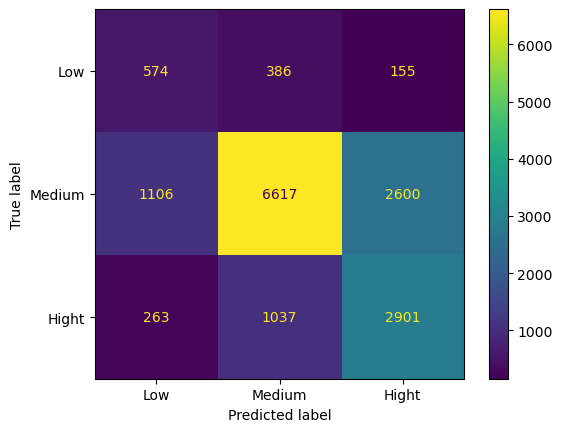

In [109]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low', 'Medium', 'Hight'])
cm_display.plot()
plt.show()